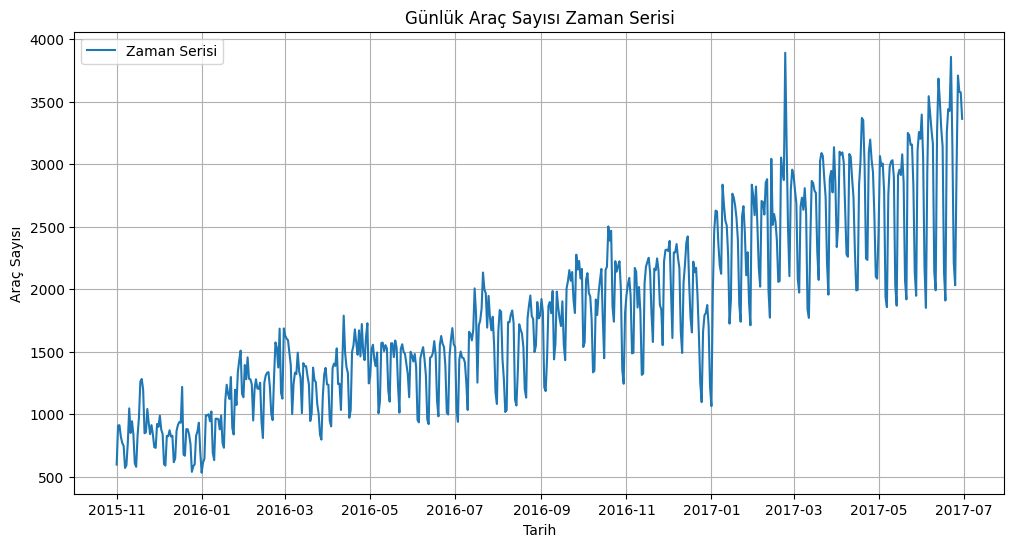

In [2]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from itertools import product
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Dosyayı yükleme ve zaman serisi oluşturma
file_path = "/content/traffic.csv"
traffic_data = pd.read_csv(file_path)



# Tarih kolonunu oluşturma
traffic_data['Date'] = pd.to_datetime(traffic_data['DateTime']).dt.date

# Günlük toplam araç sayısını hesaplama
daily_vehicle_totals_subtotal = traffic_data.groupby('Date')['Vehicles'].sum()

# Zaman serisi oluşturma
data = daily_vehicle_totals_subtotal.reset_index()
data.columns = ["Date", "Vehicles"]
data.set_index('Date', inplace=True)

# Zaman serisini tanımlama
ts = data['Vehicles']


# Zaman serisi grafiği
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Zaman Serisi')
plt.title('Günlük Araç Sayısı Zaman Serisi')
plt.xlabel('Tarih')
plt.ylabel('Araç Sayısı')
plt.legend()
plt.grid()
plt.show()


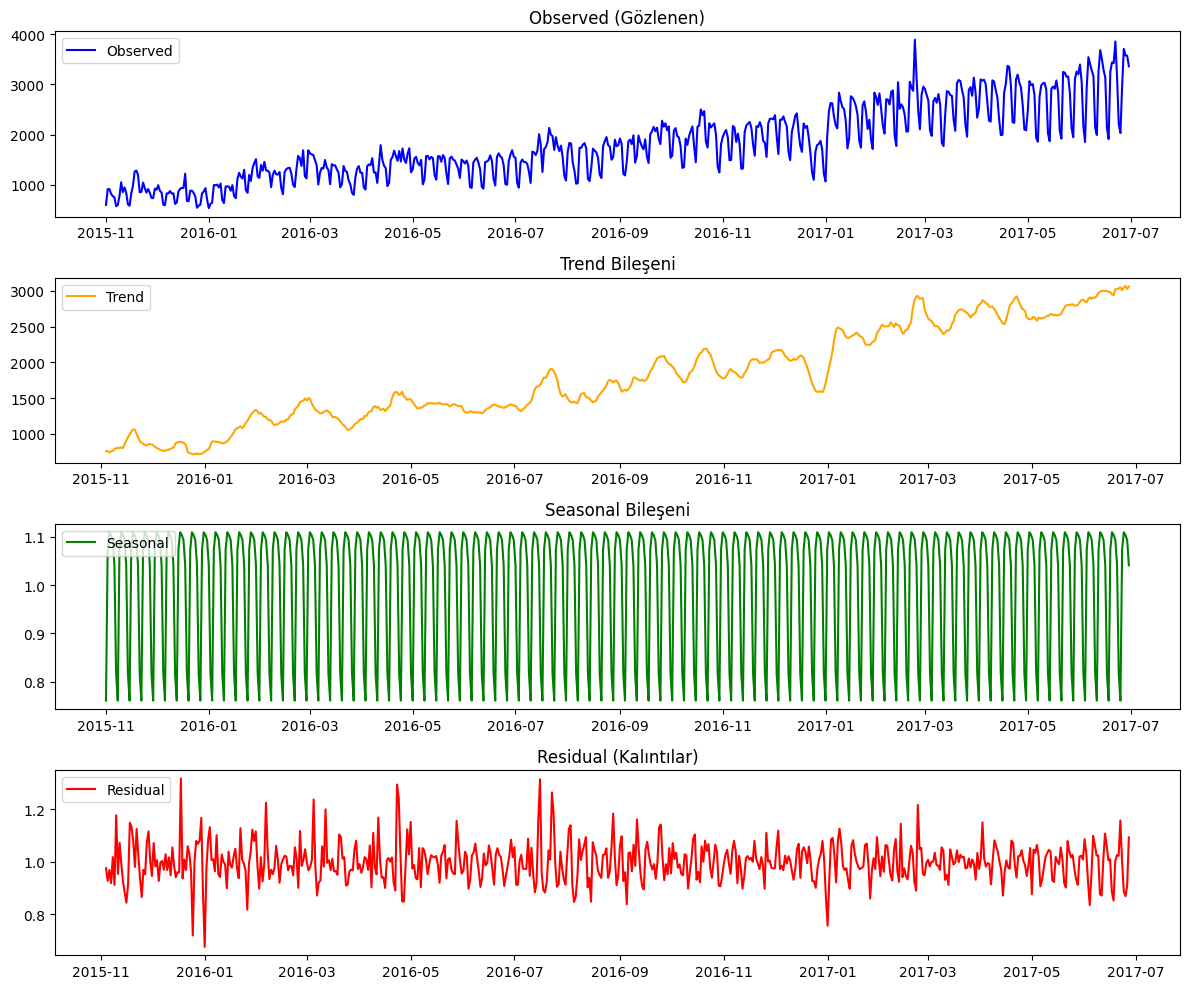

In [3]:
# Zaman serisi bileşenlerini ayrıştırma
decomposition = seasonal_decompose(ts, model='multiplicative', period=7)

# Grafik oluşturma
fig, axs = plt.subplots(4, 1, figsize=(12, 10))

# Observed (Gözlenen)
axs[0].plot(decomposition.observed, label='Observed', color='blue')
axs[0].set_title("Observed (Gözlenen)")
axs[0].legend(loc='upper left')

# Trend
axs[1].plot(decomposition.trend, label='Trend', color='orange')
axs[1].set_title("Trend Bileşeni")
axs[1].legend(loc='upper left')

# Seasonal (Sezonsallık)
axs[2].plot(decomposition.seasonal, label='Seasonal', color='green')
axs[2].set_title("Seasonal Bileşeni")
axs[2].legend(loc='upper left')

# Residuals (Kalıntılar)
axs[3].plot(decomposition.resid, label='Residual', color='red')
axs[3].set_title("Residual (Kalıntılar)")
axs[3].legend(loc='upper left')

# NaN'leri temizleyerek bileşenleri kaydetme
residuals = decomposition.resid.dropna()
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()

# Tüm grafikleri düzenleme
fig.tight_layout()
plt.show()

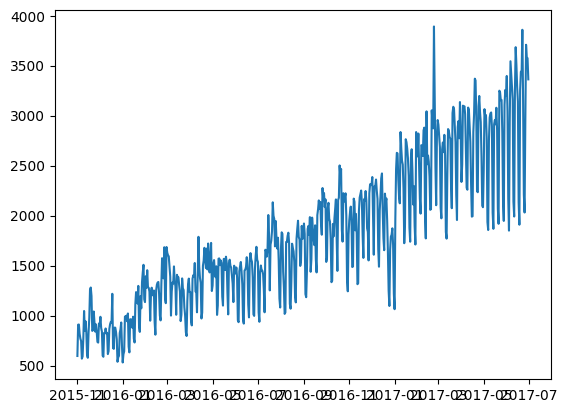

In [4]:
plt.plot(ts)

p-value: 0.9504831043579367


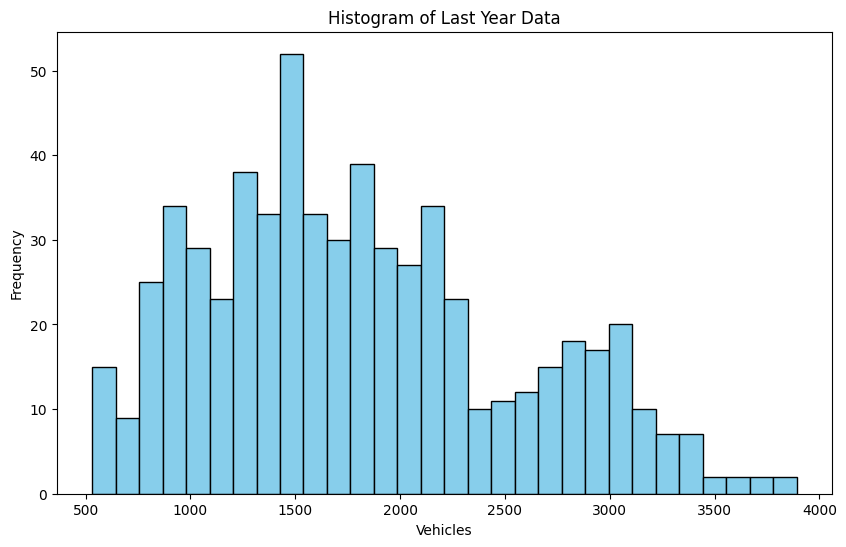

Chunk 1: Mean = 828.72, Variance = 28462.07
Chunk 2: Mean = 1131.48, Variance = 71836.75
Chunk 3: Mean = 1320.92, Variance = 54130.11
Chunk 4: Mean = 1388.18, Variance = 46187.18
Chunk 5: Mean = 1576.51, Variance = 90384.29
Chunk 6: Mean = 1879.59, Variance = 100339.91
Chunk 7: Mean = 1942.48, Variance = 109907.32
Chunk 8: Mean = 2470.75, Variance = 204597.26
Chunk 9: Mean = 2654.57, Variance = 171389.27
Chunk 10: Mean = 2876.48, Variance = 330827.54


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [5]:
# ADF Test
adf_result = adfuller(ts)
print("p-value:", adf_result[1])

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(ts, bins=30, edgecolor='k', color='skyblue')
plt.title("Histogram of Last Year Data")
plt.xlabel("Vehicles")
plt.ylabel("Frequency")
plt.show()


chunks = np.array_split(ts, 10)
for i, chunk in enumerate(chunks, 1):
    print(f"Chunk {i}: Mean = {chunk.mean():.2f}, Variance = {chunk.var():.2f}")

ADF Test p-value (Log + Diff): 6.643480614187697e-16


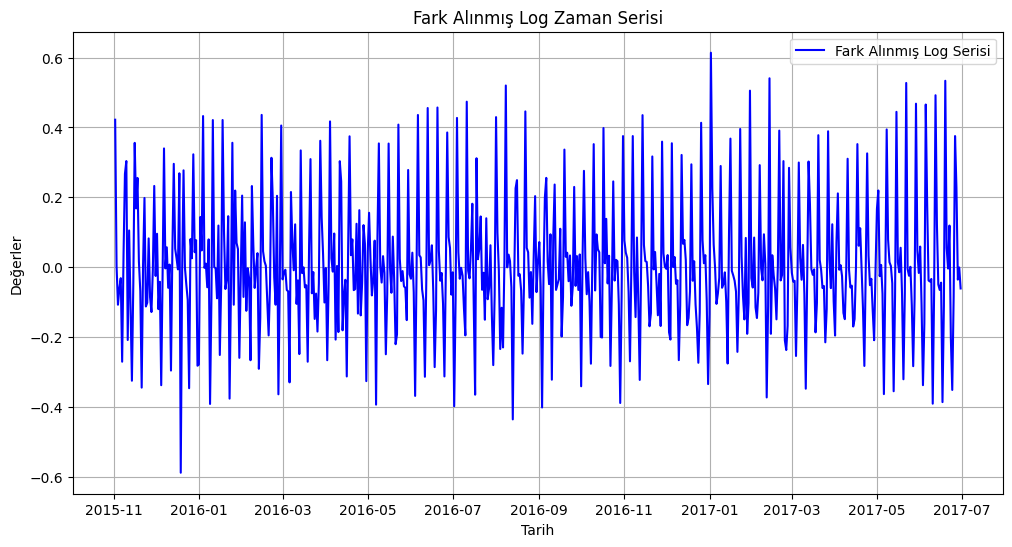

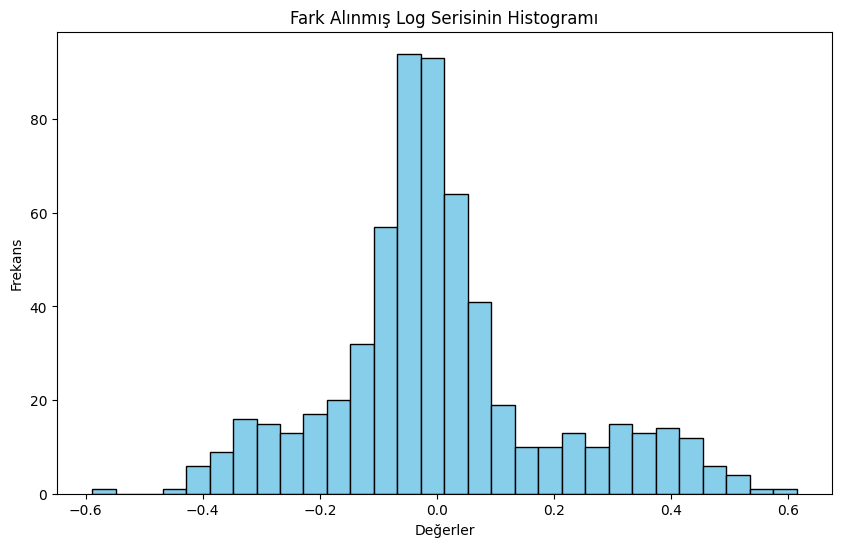

In [6]:
# Log Dönüşümü (Varyansı Stabilize Etmek)
ts_log = np.log(ts)

# Fark Alma (Birinci Dereceden Fark)
ts_diff = ts_log.diff().dropna()

# ADF Testi
adf_result_log = adfuller(ts_diff)
print("ADF Test p-value (Log + Diff):", adf_result_log[1])

# Zaman Serisi Grafiği (Fark Alınmış Log Serisi)
plt.figure(figsize=(12, 6))
plt.plot(ts_diff, label='Fark Alınmış Log Serisi', color='blue')
plt.title('Fark Alınmış Log Zaman Serisi')
plt.xlabel('Tarih')
plt.ylabel('Değerler')
plt.legend()
plt.grid()
plt.show()

# Histogram (Fark Alınmış Log Serisi)
plt.figure(figsize=(10, 6))
plt.hist(ts_diff, bins=30, edgecolor='k', color='skyblue')
plt.title("Fark Alınmış Log Serisinin Histogramı")
plt.xlabel("Değerler")
plt.ylabel("Frekans")
plt.show()




In [7]:
train_size = int(len(ts_diff) * 0.8)  # %70 eğitim, %30 test
train, test = ts_diff[:train_size], ts_diff[train_size:]


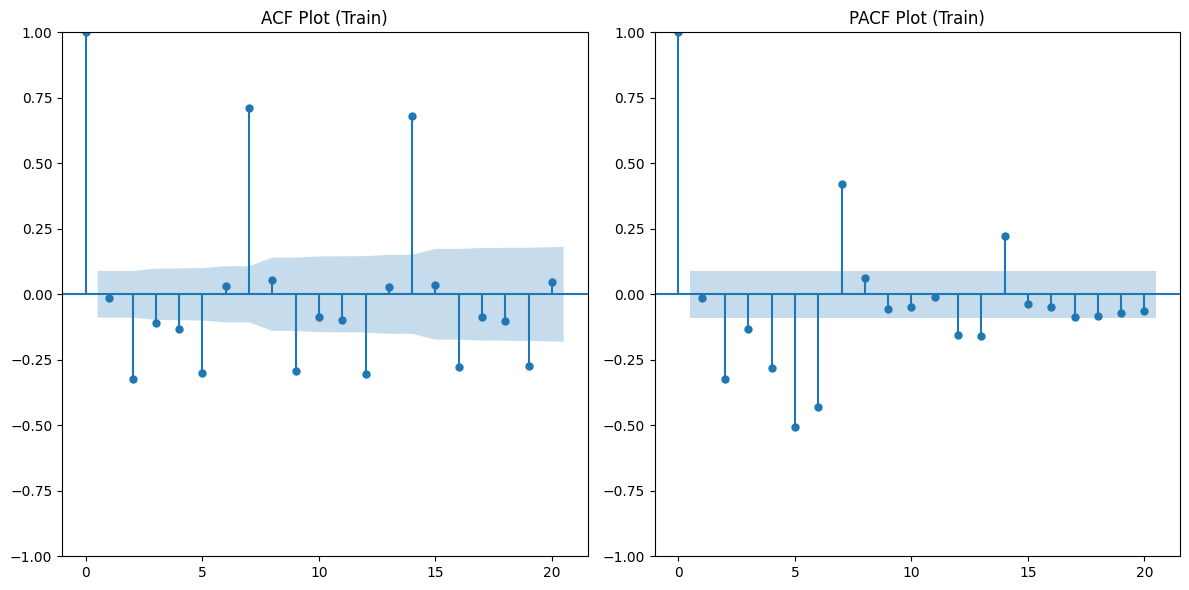

In [8]:
# ACF ve PACF Plots
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(train, lags=20, ax=plt.gca())
plt.title("ACF Plot (Train)")
plt.subplot(122)
plot_pacf(train, lags=20, ax=plt.gca())
plt.title("PACF Plot (Train)")
plt.tight_layout()
plt.show()

In [9]:

# Grid Search Ayarları
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
P = range(0, 2)
D = range(0, 2)
Q = range(0, 2)
s = [7]

parameters = list(product(p, d, q, P, D, Q, s))
results = []

# SARIMA Grid Search
for param in parameters:
    try:
        model = SARIMAX(train, order=(param[0], param[1], param[2]), seasonal_order=(param[3], param[4], param[5], param[6]))
        fit_model = model.fit(disp=False)
        results.append((param, fit_model.aic))
    except Exception as e:
        results.append((param, None))

# Sonuçları Sıralama
results = [res for res in results if res[1] is not None]  # Geçerli sonuçları filtrele
results = sorted(results, key=lambda x: x[1])  # AIC'ye göre sırala

# Tüm Modelleri Sıralama
print("SARIMA Model Sonuçları:")
for param, aic in results:
    print(f"Model: SARIMA{param}, AIC: {aic}")

# En İyi Modeli Seçme
best_param = results[0][0]
print(f"\nEn İyi Model: SARIMA{best_param}")

# En İyi Model ile Tahmin
best_model = SARIMAX(train, order=(best_param[0], best_param[1], best_param[2]), seasonal_order=(best_param[3], best_param[4], best_param[5], best_param[6]))
fit_best_model = best_model.fit(disp=False)

# Tahmin
forecast = fit_best_model.forecast(steps=len(test))
forecast.index = test.index

# Performans Değerlendirme
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE (En İyi SARIMA Tahmini): {rmse:.3f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

SARIMA Model Sonuçları:
Model: SARIMA(1, 0, 1, 1, 0, 1, 7), AIC: -863.5011647440124
Model: SARIMA(2, 0, 1, 1, 0, 1, 7), AIC: -862.3108956400123
Model: SARIMA(2, 0, 2, 1, 0, 1, 7), AIC: -858.2677291505054
Model: SARIMA(1, 0, 1, 0, 1, 1, 7), AIC: -857.2861483150058
Model: SARIMA(1, 0, 2, 0, 1, 1, 7), AIC: -857.0329045414416
Model: SARIMA(2, 0, 1, 0, 1, 1, 7), AIC: -856.9391079722599
Model: SARIMA(1, 0, 2, 1, 1, 1, 7), AIC: -856.8758566520485
Model: SARIMA(1, 0, 1, 1, 1, 1, 7), AIC: -856.7849716375772
Model: SARIMA(2, 0, 1, 1, 1, 1, 7), AIC: -856.7674842939239
Model: SARIMA(1, 0, 2, 1, 0, 1, 7), AIC: -853.1209003757949
Model: SARIMA(2, 0, 2, 0, 1, 1, 7), AIC: -853.0341437594236
Model: SARIMA(2, 0, 2, 1, 1, 1, 7), AIC: -852.8290962756048
Model: SARIMA(0, 0, 2, 1, 0, 1, 7), AIC: -847.6678981897153
Model: SARIMA(0, 0, 2, 0, 1, 1, 7), AIC: -842.6863858501777
Model: SARIMA(0, 0, 2, 1, 1, 1, 7), AIC: -840.8277628669933
Model: SARIMA(1, 1, 2, 0, 1, 1, 7), AIC: -837.4575257453479
Model: SARIMA(1,

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA Modeli RMSE: 853.400


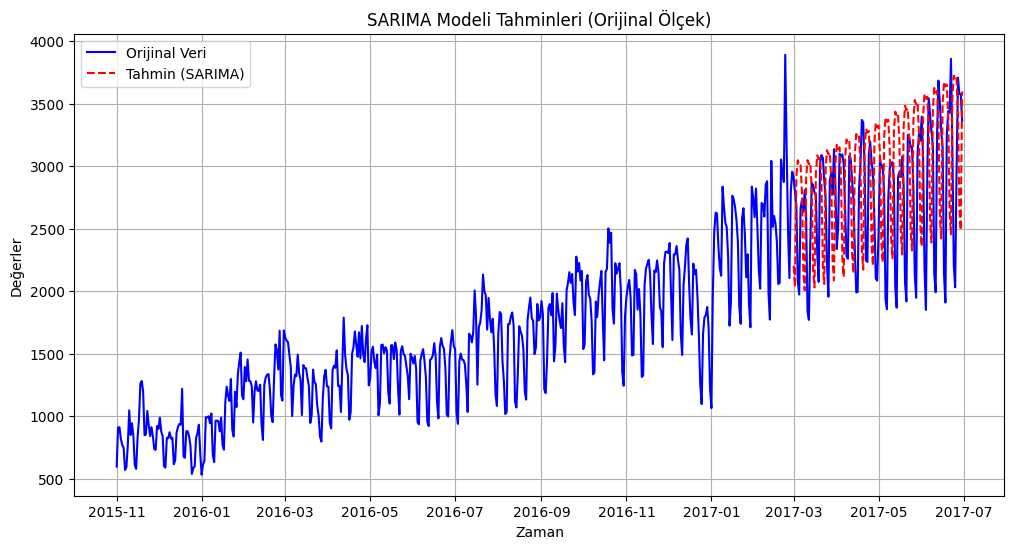

In [10]:

# En iyi parametreler
best_param = (1, 0, 1, 1, 0, 1, 7)  # (p, d, q, P, D, Q, s)

# SARIMA Modelini Eğitme
sarima_model = SARIMAX(ts_diff,  # Log ve differencing uygulanmış veri
                       order=(best_param[0], best_param[1], best_param[2]),
                       seasonal_order=(best_param[3], best_param[4], best_param[5], best_param[6]))
fit_sarima_model = sarima_model.fit(disp=False)

# Tahmin Yapma
forecast_diff = fit_sarima_model.forecast(steps=len(test))  # Test seti uzunluğu kadar tahmin
forecast_diff.index = test.index

# Differencing'i Tersine Çevirme
forecast_log = forecast_diff.cumsum() + ts_log.iloc[-len(test)]  # İlk referans değer eklenir

# Log Tersine Çevirme (Orijinal Ölçeğe Dönüş)
forecast_original = np.exp(forecast_log)

# Gerçek Veriyle Karşılaştırma İçin Orijinal Veri
original_ts = np.exp(ts_log)  # Orijinal zaman serisi

# Performans Değerlendirme
rmse = np.sqrt(mean_squared_error(original_ts[-len(test):], forecast_original))
print(f"SARIMA Modeli RMSE: {rmse:.3f}")

# Tahminleri Görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(original_ts, label='Orijinal Veri', color='blue')
plt.plot(forecast_original, label='Tahmin (SARIMA)', linestyle='--', color='red')
plt.title('SARIMA Modeli Tahminleri (Orijinal Ölçek)')
plt.xlabel('Zaman')
plt.ylabel('Değerler')
plt.legend()
plt.grid()
plt.show()


Now, We will use LSTM Model.


In [11]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Sütun adlarını temizleme (başındaki ve sonundaki boşlukları kaldırma)
data.columns = data.columns.str.strip()

# Tarih kolonunu dönüştürme ve sıralama
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])  # DateTime kolonunu datetime formatına dönüştürme
traffic_data['Date'] = traffic_data['DateTime'].dt.date
traffic_data = traffic_data.groupby('Date')['Vehicles'].sum().reset_index()
traffic_data.columns = ['Date', 'Vehicles']
traffic_data = traffic_data.sort_values('Date')

# Zaman serisini ayarlama
ts = traffic_data['Vehicles'].values.reshape(-1, 1)

# Veriyi ölçeklendirme
scaler = MinMaxScaler(feature_range=(0, 1))
ts_scaled = scaler.fit_transform(ts)

# Eğitim ve test setlerine ayırma
train_size = int(len(ts_scaled) * 0.8)
train, test = ts_scaled[:train_size], ts_scaled[train_size:]

# LSTM girdi formatına dönüştürme
def create_dataset(dataset, look_back=1):
    dataset = np.array(dataset)  # Numpy array'e dönüştürme
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 14  # Daha fazla geçmiş kullanmak için artırıldı
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# LSTM girdi formatına (örneğin, 3D) dönüştürme
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM modelini tanımlama
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(look_back, 1)))  # Daha fazla nöron
model.add(Dropout(0.2))  # Overfitting'i azaltmak için Dropout
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Modeli derleme (daha düşük öğrenme oranı ile)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Modeli eğitme
model.fit(X_train, y_train, batch_size=16, epochs=150, verbose=1, validation_data=(X_test, y_test))

# Tahmin yapma
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Tahminleri orijinal ölçeğe dönüştürme
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))



Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0435 - val_loss: 0.0315
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0097 - val_loss: 0.0232
Epoch 3/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0102 - val_loss: 0.0260
Epoch 4/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0082 - val_loss: 0.0259
Epoch 5/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0096 - val_loss: 0.0326
Epoch 6/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0098 - val_loss: 0.0243
Epoch 7/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0095 - val_loss: 0.0254
Epoch 8/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0087 - val_loss: 0.0238
Epoch 9/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0094 - val_loss: 0.0269
Epoch 10/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0100 - val_loss: 0.0306
Epoch 11/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0089 - val_loss: 0.0238
Epoch 12/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0

In [12]:
# Performans değerlendirme
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 165.58
Test RMSE: 245.25


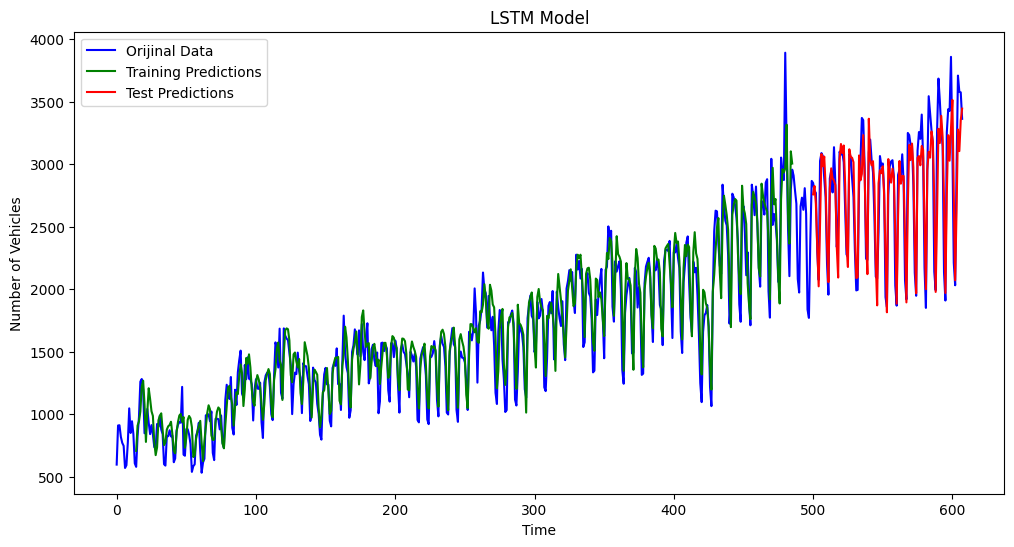

In [14]:
# Tahminleri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(ts_scaled), label='Orijinal Data', color='blue')
plt.plot(range(look_back, look_back + len(train_predict)), train_predict, label='Training Predictions', color='green')
plt.plot(range(len(ts_scaled) - len(test_predict), len(ts_scaled)), test_predict, label='Test Predictions', color='red')
plt.title('LSTM Model')
plt.xlabel('Time')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()